In [ ]:
import torch
from PIL import Image
from transformers import AutoModel, AutoProcessor
import os
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision.transforms.functional import to_pil_image
from torch.optim import Adam
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

processor = AutoProcessor.from_pretrained("facebook/ijepa_vith14_1k")
backbone = AutoModel.from_pretrained(
    "facebook/ijepa_vith14_1k",
    torch_dtype="auto",
    attn_implementation="sdpa"
).to(device)
backbone.eval()

def infer(image: Image.Image):
    """
    image: PIL.Image
    returns: embedding tensor shape (1, 16, 16, 1280) on device
    """
    inputs = processor(image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = backbone(**inputs)
    # Reshape to spatial format: (1, 16, 16, 1280)
    emb = outputs.last_hidden_state.reshape((1, 16, 16, 1280))
    return emb

2025-08-15 17:14:45.503836: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755278085.681661      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755278085.739953      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda


preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/497 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


model.safetensors:   0%|          | 0.00/2.52G [00:00<?, ?B/s]

In [ ]:
os.makedirs("cache", exist_ok=True)
TRAIN_EMB_FILE = "cache/cifar10_train_embeddings.pt"
TRAIN_LBL_FILE = "cache/cifar10_train_labels.pt"
TEST_EMB_FILE  = "cache/cifar10_test_embeddings.pt"
TEST_LBL_FILE  = "cache/cifar10_test_labels.pt"

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # ImageNet normalization
])

def compute_embeddings(dataset, batch_size=32, save_emb=None, save_lbl=None):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    all_embs = []
    all_lbls = []
    
    for imgs, labels in loader:
        batch_embs = []
        for img in imgs:
            pil = to_pil_image(img)
            e = infer(pil)  # (1, 16, 16, 1280) on device
            batch_embs.append(e.cpu())
        batch_embs = torch.cat(batch_embs, dim=0)  # B x 16 x 16 x 1280
        all_embs.append(batch_embs)
        all_lbls.append(labels)
        
    embs = torch.cat(all_embs, dim=0)
    lbls = torch.cat(all_lbls, dim=0)
    
    if save_emb:
        torch.save(embs, save_emb)
    if save_lbl:
        torch.save(lbls, save_lbl)
    return embs, lbls

print("Loading CIFAR-10...")
train_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_ds  = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_subset_size = 2000   
test_subset_size  = 1000

if train_subset_size is not None:
    train_ds = Subset(train_ds, list(range(train_subset_size)))
if test_subset_size is not None:
    test_ds = Subset(test_ds, list(range(test_subset_size)))

print("Computing train embeddings...")
train_embs, train_lbls = compute_embeddings(train_ds, batch_size=32,
                                          save_emb=TRAIN_EMB_FILE, save_lbl=TRAIN_LBL_FILE)
print("Train embeddings shape:", train_embs.shape)

print("Computing test embeddings...")
test_embs, test_lbls = compute_embeddings(test_ds, batch_size=32,
                                        save_emb=TEST_EMB_FILE, save_lbl=TEST_LBL_FILE)
print("Test embeddings shape:", test_embs.shape)
print("Done. Files saved in cache/")

Loading CIFAR-10...


100%|██████████| 170M/170M [00:04<00:00, 34.9MB/s] 


Computing train embeddings...
Train embeddings shape: torch.Size([2000, 16, 16, 1280])
Computing test embeddings...
Test embeddings shape: torch.Size([1000, 16, 16, 1280])
Done. Files saved in cache/


In [ ]:
class QuickGELUActivation(nn.Module):
    """
    Applies GELU approximation that is fast but somewhat inaccurate.
    """
    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return input * torch.sigmoid(1.702 * input) 
        
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()

        # First convolution layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = QuickGELUActivation()

        # Second convolution layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Skip connection 
        self.skip_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        identity = self.skip_conv(x)  # Identity for skip connection

        # Pass through the first convolutional layer
        out = self.relu(self.bn1(self.conv1(x)))

        # Pass through the second convolutional layer
        out = self.bn2(self.conv2(out))

        # Add the skip connection to the output
        out += identity
        out = self.relu(out)  # Final activation

        return out

class Decoder(nn.Module):
    def __init__(self, emb_size):
        super(Decoder, self).__init__()

        # Stage 1: Upsample from 16x16 to 32x32, reduce channels
        self.upconv1 = nn.ConvTranspose2d(emb_size, emb_size // 2, kernel_size=4, stride=2, padding=1)
        self.resblock1 = ResidualBlock(emb_size // 2, emb_size // 2)

        # Stage 2: Upsample from 32x32 to 64x64, reduce channels
        self.upconv2 = nn.ConvTranspose2d(emb_size // 2, emb_size // 4, kernel_size=4, stride=2, padding=1)
        self.resblock2 = ResidualBlock(emb_size // 4, emb_size // 4)

        # Stage 3: Upsample from 64x64 to 128x128, reduce channels
        self.upconv3 = nn.ConvTranspose2d(emb_size // 4, emb_size // 8, kernel_size=4, stride=2, padding=1)
        self.resblock3 = ResidualBlock(emb_size // 8, emb_size // 8)

        # Stage 4: Upsample from 128x128 to 224x224 (approximately), reduce channels
        self.upconv4 = nn.ConvTranspose2d(emb_size // 8, emb_size // 16, kernel_size=4, stride=2, padding=1)
        # Note: 128->256, so we need to crop to 224 or adjust
        self.resblock4 = ResidualBlock(emb_size // 16, emb_size // 16)
        self.resblock5 = ResidualBlock(emb_size // 16, emb_size // 16)
        self.resblock6 = ResidualBlock(emb_size // 16, emb_size // 16)

        # Final convolution to reduce channels to 3 (RGB output)
        self.final_conv = nn.Conv2d(emb_size // 16, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # Stage 1: 16x16 -> 32x32
        x = self.upconv1(x)
        x = self.resblock1(x)

        # Stage 2: 32x32 -> 64x64
        x = self.upconv2(x)
        x = self.resblock2(x)

        # Stage 3: 64x64 -> 128x128
        x = self.upconv3(x)
        x = self.resblock3(x)

        # Stage 4: 128x128 -> 256x256
        x = self.upconv4(x)
        x = self.resblock4(x)
        x = self.resblock5(x)
        x = self.resblock6(x)

        if x.size(-1) > 224:
            x = x[:, :, :224, :224]

        # Final convolution to output RGB image
        x = self.final_conv(x)
        return x

class R(nn.Module):
    def __init__(self, embed_dim, decoder):
        super(R, self).__init__()
        self.decoder = decoder

    def forward(self, ijepa_feats, image):
        """
        ijepa_feats: (B, 16, 16, 1280) from IJepa patch embeddings
        image:      (B, 3, 224, 224)   target image
        """
        
        features = ijepa_feats.permute(0, 3, 1, 2)

      
        recovered_image = self.decoder(features)  # (B, 3, 224, 224)

        
        recovered_norm = recovered_image / (recovered_image.norm(dim=1, keepdim=True) + 1e-8)
        image_norm = image / (image.norm(dim=1, keepdim=True) + 1e-8)
        in_out_cos = torch.einsum('bdij,bdij->bij', recovered_norm, image_norm)

        val_dict = {
            'in_out_cos': in_out_cos,
            'transposed_input': recovered_image
        }
        return [recovered_image, image, val_dict]

    def loss_function(self, *args):
        recons = args[0]   
        target = args[1]   


        recons_loss = F.mse_loss(recons, target)


        normed_recons = recons / (torch.norm(recons, dim=1, keepdim=True) + 1e-8)
        normed_target = target / (torch.norm(target, dim=1, keepdim=True) + 1e-8)
        latent_cross_product = torch.einsum('bdij,bdij->bij', normed_recons, normed_target)
        cos_loss = latent_cross_product.mean() 

        total_loss = recons_loss

        return {
            'loss': total_loss,
            'mse': recons_loss,
            'cos': cos_loss
        }

In [ ]:
class ImageFeatureDataset(Dataset):
    def __init__(self, images_dataset, features_file):
        """
        images_dataset: torchvision dataset (returns images & labels)
        features_file:  path to .pt file with precomputed features
                        shape should be (N, 16, 16, embed_dim)
        """
        self.images_dataset = images_dataset
        self.features = torch.load(features_file)  # Tensor
        assert len(self.features) == len(self.images_dataset), \
            f"Features length {len(self.features)} and dataset length {len(self.images_dataset)} must match"

    def __len__(self):
        return len(self.images_dataset)

    def __getitem__(self, idx):
        image, _ = self.images_dataset[idx] 
        feats = self.features[idx]
        return image, feats

def train_model(model, dataloader, epochs=10, lr=1e-4, device="cuda"):
    model.to(device)
    optimizer = Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_mse = 0.0
        running_cos = 0.0

        for batch_idx, (images, features) in enumerate(dataloader):
            # Move to device
            images = images.to(device)        # (B, 3, 224, 224)
            features = features.to(device)    # (B, 16, 16, 1280)

            # Forward pass
            outputs = model(features, images)
            recons, target, val_dict = outputs

            # Compute loss
            loss_dict = model.loss_function(recons, target)
            loss = loss_dict["loss"]

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_mse += loss_dict["mse"].item()
            running_cos += loss_dict["cos"].item()


        avg_loss = running_loss / len(dataloader)
        avg_mse = running_mse / len(dataloader)
        avg_cos = running_cos / len(dataloader)
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f} MSE: {avg_mse:.4f} Cos: {avg_cos:.4f}")

    print("Training complete!")

In [5]:
# Create paired datasets
train_pair_ds = ImageFeatureDataset(train_ds, TRAIN_EMB_FILE)
test_pair_ds  = ImageFeatureDataset(test_ds, TEST_EMB_FILE)

# Create dataloaders
train_loader = DataLoader(train_pair_ds, batch_size=8, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_pair_ds, batch_size=8, shuffle=False, num_workers=2)

# Initialize model
decoder = Decoder(emb_size=1280) 
model = R(embed_dim=1280, decoder=decoder)

print(f"Model initialized. Starting training...")
print(f"Train dataset size: {len(train_pair_ds)}")
print(f"Test dataset size: {len(test_pair_ds)}")

# Train
train_model(model, train_loader, epochs=50, lr=1e-4, device=device)

Model initialized. Starting training...
Train dataset size: 2000
Test dataset size: 1000
Epoch [1/50] - Loss: 1.0768 MSE: 1.0768 Cos: 0.1493
Epoch [2/50] - Loss: 0.8956 MSE: 0.8956 Cos: 0.2801
Epoch [3/50] - Loss: 0.7808 MSE: 0.7808 Cos: 0.3536
Epoch [4/50] - Loss: 0.7188 MSE: 0.7188 Cos: 0.3921
Epoch [5/50] - Loss: 0.6734 MSE: 0.6734 Cos: 0.4273
Epoch [6/50] - Loss: 0.6194 MSE: 0.6194 Cos: 0.4560
Epoch [7/50] - Loss: 0.5770 MSE: 0.5770 Cos: 0.4933
Epoch [8/50] - Loss: 0.5276 MSE: 0.5276 Cos: 0.5309
Epoch [9/50] - Loss: 0.5006 MSE: 0.5006 Cos: 0.5537
Epoch [10/50] - Loss: 0.4567 MSE: 0.4567 Cos: 0.5836
Epoch [11/50] - Loss: 0.4161 MSE: 0.4161 Cos: 0.6148
Epoch [12/50] - Loss: 0.3857 MSE: 0.3857 Cos: 0.6346
Epoch [13/50] - Loss: 0.3615 MSE: 0.3615 Cos: 0.6533
Epoch [14/50] - Loss: 0.3312 MSE: 0.3312 Cos: 0.6747
Epoch [15/50] - Loss: 0.3067 MSE: 0.3067 Cos: 0.6945
Epoch [16/50] - Loss: 0.2850 MSE: 0.2850 Cos: 0.7110
Epoch [17/50] - Loss: 0.2562 MSE: 0.2562 Cos: 0.7311
Epoch [18/50] - Los

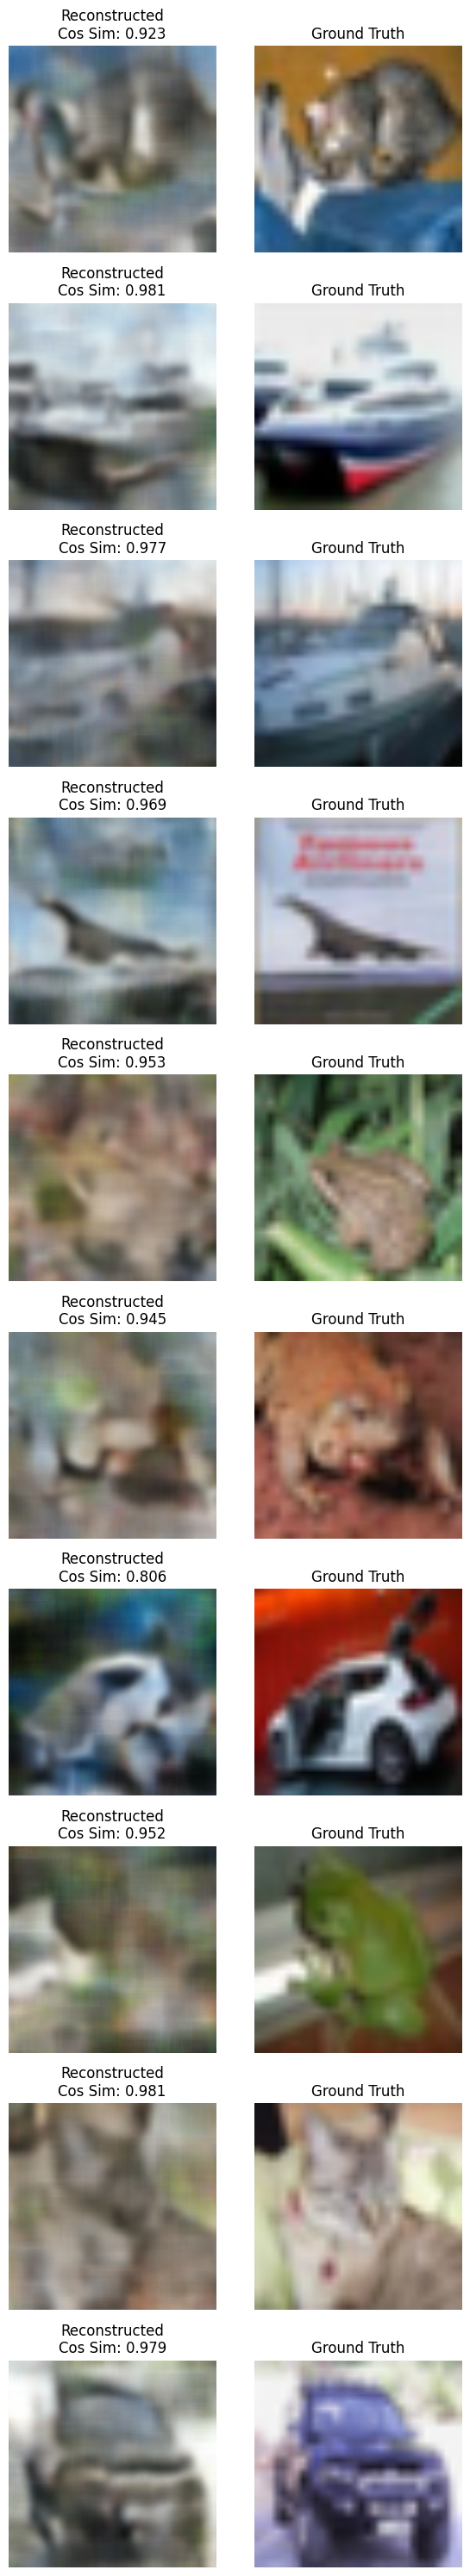

In [ ]:
def show_reconstructions(embeddings, images, decoder, device, n=10):
    """
    embeddings: list or tensor of shape (N, H, W, C) embeddings
    images: list of (img, label) tuples from dataset
    decoder: trained decoder model
    device: torch device
    n: number of samples to visualize
    """
    decoder.eval()
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    
    fig, axes = plt.subplots(n, 2, figsize=(6, 3 * n))
    for i in range(n):
        emb = embeddings[i:i+1].to(device)
        gt_img, _ = images[i]
        
        with torch.no_grad():
            features = emb.permute(0, 3, 1, 2)
            recon = decoder(features)
            recon = recon[0].cpu().permute(1, 2, 0)
            

            recon = recon * std + mean
            recon = recon.clamp(0, 1)
            
            gt_img = gt_img.permute(1, 2, 0)
            gt_img = gt_img * std + mean
            gt_img = gt_img.clamp(0, 1)
            
 
            recon_flat = recon.flatten()
            gt_flat = gt_img.flatten()
            cos_sim = torch.nn.functional.cosine_similarity(recon_flat.unsqueeze(0), gt_flat.unsqueeze(0))
            
        axes[i, 0].imshow(recon)
        axes[i, 0].set_title(f"Reconstructed\nCos Sim: {cos_sim.item():.3f}")
        axes[i, 0].axis("off")
        axes[i, 1].imshow(gt_img)
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis("off")
    plt.tight_layout()
    plt.show()
# Example usage
test_embeddings = torch.load("cache/cifar10_test_embeddings.pt")
show_reconstructions(test_embeddings, test_ds, decoder, device, n=10)